In [1]:
# Load required packages
library(Biobase)
library(CMScaller)
library(data.table)
library(purrr)
library(dplyr)
library(forcats)

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: 'generics'


The following objects are masked from 'package:base':

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, saveRDS, table, tapply, unique,
    unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("

In [2]:
# Load annotation data
ann <- read.table("../../data/ann.csv", sep = ",", header = TRUE, row.names = 1)

# Load expression data (using data.table for efficiency)
log_tmps <- fread("../../data/log_tpms_from_fpkm_hgnc_filtered_by_ann.csv")

# Prepare expression matrix
sample_ids <- log_tmps$sample_id
expr_df <- as.data.frame(log_tmps[, -1, with = FALSE])
rownames(expr_df) <- sample_ids

In [3]:
# Convert to matrix and transpose (genes as rows, samples as columns)
expr_mat <- t(as.matrix(expr_df))
rownames(expr_mat) <- colnames(log_tmps)[-1]  # Gene names as row names
colnames(expr_mat) <- sample_ids             # Sample IDs as column names
storage.mode(expr_mat) <- "numeric"          # Ensure numeric data type

# Verify annotation matches expression data
if(!all(rownames(ann) == colnames(expr_mat))) {
  stop("Annotation and expression sample IDs don't match!")
}

# Create ExpressionSet object
phen_data <- new("AnnotatedDataFrame", data = ann)
expr_dat <- ExpressionSet(assayData = expr_mat, phenoData = phen_data)

# Extract expression matrix
counts <- exprs(expr_dat)

1029/19388 rownames [NA.number] (no valid translation)

0/19388 rownames [id.number] (translation gives duplicates)

performing log2-transform and quantile normalization...

cosine correlation distance

17/530 templates features not in emat, discarded

80 samples; 4 classes; 79-227 features/class

serial processing; 1000 permutation(s)...

predicted samples/class (FDR<0.05)




CMS1 CMS2 CMS3 CMS4 <NA> 
   7   16    9   26   22 


22/80 samples set to NA



,prediction,d.CMS1,d.CMS2,d.CMS3,d.CMS4,p.value,FDR
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18R649_0010,CMS4,0.6941103,0.7634178,0.6233271,0.5566742,0.0010000,0.001632653
18R654_0015,NA,0.7491865,0.6901596,0.7061519,0.8717155,0.7232767,0.781920782
18R669_0001,CMS3,0.6904723,0.7295721,0.6214577,0.8010410,0.0010000,0.001632653
18R670_0002,CMS4,0.6941481,0.6510916,0.7813200,0.6204606,0.0010000,0.001632653
18R674_0006,CMS4,0.6931502,0.6934316,0.7219994,0.4059597,0.0010000,0.001632653
18R678_0010,CMS4,0.7284895,0.7141267,0.7284297,0.6113539,0.0010000,0.001632653


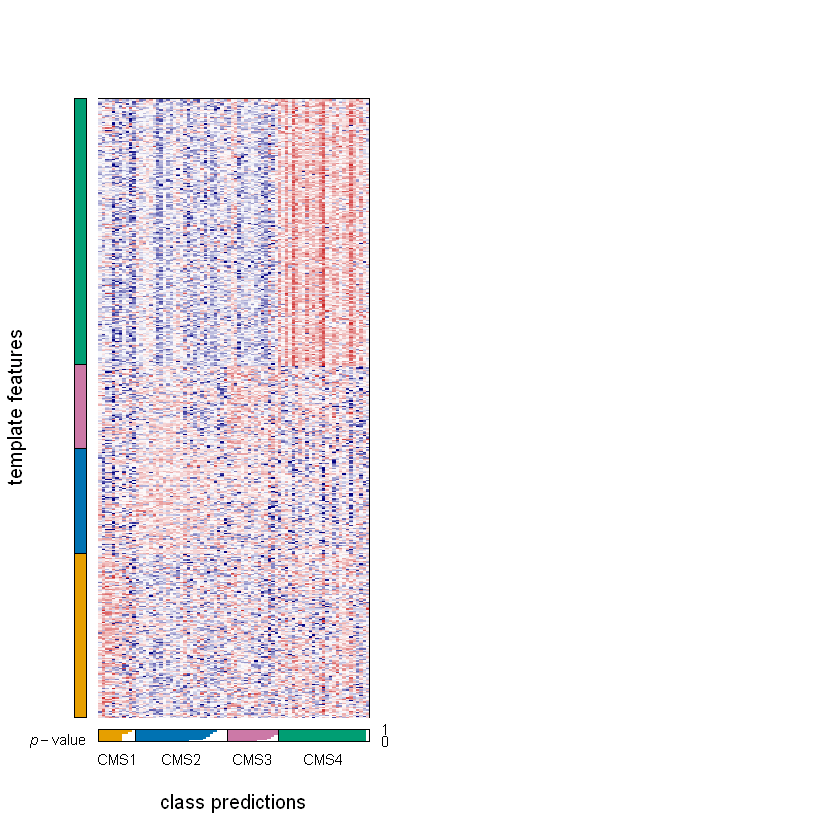

In [4]:
# Run CMS classification with visualization
par(mfrow = c(1, 2))  # Set up 1x2 plot layout
cms_results <- CMScaller(
  emat = counts,
  RNAseq = TRUE,      # Specify RNA-seq data
  FDR = 0.05,         # False discovery rate threshold
  rowNames = "symbol" # Indicate row names are gene symbols
)

head(cms_results)

In [5]:
cms_results$prediction
length(cms_results$prediction)
names(cms_results$prediction)

[1] CMS4 <NA> CMS3 CMS4 CMS4 CMS4 <NA> CMS4 CMS3 CMS4 CMS4 CMS2 CMS1 CMS3 CMS4
[16] <NA> <NA> CMS3 CMS3 CMS1 CMS4 <NA> CMS2 <NA> <NA> CMS2 <NA> CMS4 CMS4 CMS4
[31] CMS1 CMS4 <NA> <NA> CMS2 CMS4 CMS3 <NA> CMS2 CMS4 <NA> CMS2 CMS2 <NA> <NA>
[46] <NA> CMS4 <NA> CMS4 CMS2 CMS4 CMS1 CMS1 CMS2 CMS2 CMS1 <NA> CMS4 <NA> CMS4
[61] CMS4 <NA> CMS2 CMS2 CMS2 CMS4 CMS4 <NA> CMS3 CMS3 CMS4 <NA> CMS2 CMS1 <NA>
[76] CMS4 CMS2 CMS2 CMS4 CMS3
Levels: CMS1 CMS2 CMS3 CMS4

[1] 80

NULL

In [6]:
# 1. Extract CMS predictions
cms_calls <- data.frame(
  sample_id = colnames(expr_mat),  # Use your known sample IDs
  CMS = as.character(cms_results$prediction)
)

cms_calls$CMS[is.na(cms_calls$CMS)] <- "unclassified"

# 2. Load original annotation (if not already loaded)
ann <- read.table("../../data/ann.csv", sep = ",", header = TRUE)

# 3. Merge CMS calls with annotation by sample_id
ann_with_cms <- merge(ann, cms_calls, by = "sample_id", all.x = TRUE)

# 4. Save merged data
write.csv(ann_with_cms, "../../data/ann_with_cms.csv", row.names = FALSE)